In [3]:
import torch
import PIL
import os
import numpy as np
from PIL import Image
import torchvision
from torchvision import transforms
from efficientunet import *
import random
import matplotlib.pyplot as plt
from dataset import  RetinalDataset
from model import get_torchvision_model

ModuleNotFoundError: No module named 'src'

# Loading model

In [17]:
def get_torchvision_model(net_type, is_trained, num_classes):
    """ Get torchvision model

    Parameters
    ----------
    net_type: str
        deep network type
    is_trained: boolean
        use pretrained ImageNet
    num_classes: int
        number of classes

    Returns
    -------
    nn.Module
        model based on net_type
    """
    return CustomEfficientNet(net_type, is_trained, num_classes)

class CustomEfficientNet(nn.Module):
    def __init__(self, net_type, is_trained, num_classes):
        super().__init__()
        if net_type.endswith("b0"):
            self.net = get_efficientunet_b0(out_channels=num_classes, concat_input=True, pretrained = is_trained)
        elif net_type.endswith("b1"):
            self.net = get_efficientunet_b1(out_channels=num_classes, concat_input=True, pretrained = is_trained)
        elif net_type.endswith("b2"):
            self.net = get_efficientunet_b2(out_channels=num_classes, concat_input=True, pretrained = is_trained)
        elif net_type.endswith("b3"):
            self.net = get_efficientunet_b3(out_channels=num_classes, concat_input=True, pretrained =True)
        elif net_type.endswith("b4"):
            self.net = get_efficientunet_b4(out_channels=num_classes, concat_input=True, pretrained = is_trained)
        elif net_type.endswith("b5"):
            self.net = get_efficientunet_b5(out_channels=num_classes, concat_input=True, pretrained = is_trained)
        elif net_type.endswith("b6"):
            self.net = get_efficientunet_b6(out_channels=num_classes, concat_input=True, pretrained = is_trained)
        else:
            self.net = get_efficientunet_b7(out_channels=num_classes, concat_input=True, pretrained = is_trained)
            
    
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.net(x)
        if not self.training:
             x = self.sigmoid(x)
        return x


In [47]:
model = get_torchvision_model("b3", True, 1)

In [48]:
state_dict = torch.load("/home/vinhng/OCTA/FAZ-extraction/models/center_crop_efficientunet_b3_model.pth")
state_dict = state_dict["state"]
model.load_state_dict(state_dict)

<All keys matched successfully>

# Transformation

In [49]:
im = Image.open("/home/vinhng/OCTA/dataset/valid/raw/HP-022 OD 2017-11-20T103204 OCTA  07_DVC PARon v6.9.5.100.png_cropped.png").convert("RGB")
gt = Image.open("/home/vinhng/OCTA/dataset/valid/mask/HP-022 OD 2017-11-20T103204 OCTA  07_DVC PARon v6.9.5.100.png_cropped.png")

In [50]:
def train_transformation(image, mask, size):
    tensor_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=[-45, 45], translate=[0.15, 0.15], scale=[1.0, 1.2]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5)], p=0.85),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=[-45, 45], translate=[0.15, 0.15], scale=[1.0, 1.2]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5)], p=0.85),
        transforms.ToTensor()
    ])
    
    #apply transform to image and grouth truth:
    seed = np.random.randint(2147483647) # make a seed with numpy generator 
    random.seed(seed)
    image = tensor_transform(image)
    random.seed(seed) # apply this seed to target tranfsorms
    mask = mask_transform(mask)
#     mask = torch.ByteTensor(np.array(mask))

    return image, mask
def inference_transformation(image, mask, size):
    """ Transform image for validation

    Parameters
    ----------
    image: PIL.Image
        image to transform
    size: int
        size to scale

    Returns
    -------

    """
    tensor_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.CenterCrop(150),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.CenterCrop(150),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    #apply transform to image and grouth truth:
    image = tensor_transform(image)
    mask = mask_transform(mask)
#     mask = torch.ByteTensor(np.array(mask))

    return image, mask

In [51]:
image, mask = inference_transformation(im, gt, 300)

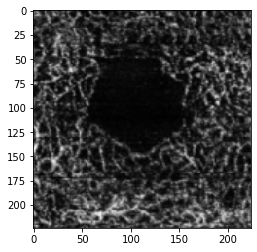

In [52]:
plt.imshow(image.permute(1,2,0))

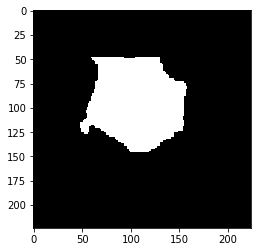

In [53]:
plt.imshow(mask.squeeze(0), cmap='gray')

In [54]:
test = image.unsqueeze(0)
test = model(test)
test = (test.to("cpu").detach().numpy() > 0.6)*1

In [55]:
test = test.reshape((224,224))
test.shape

(224, 224)

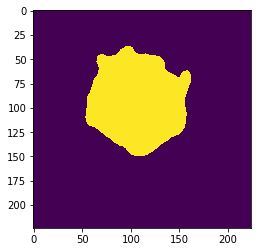

In [56]:
plt.imshow(test)

# Loading dataset

In [57]:
test_set = RetinalDataset("/home/vinhng/OCTA/dataset/valid/raw", 300, inference_transformation, phase = 'valid')
test_loader = torch.utils.data.DataLoader(test_set, batch_size =4, shuffle=False, num_workers=4)

In [58]:
def scoring(gt, pred, thresh_hold = 0.5):
        gt = gt.to("cpu").numpy()
        pred = (pred.to("cpu").detach().numpy() > thresh_hold) * 1
        intersection = np.logical_and(pred, gt).sum()
        union = np.logical_or(pred, gt).sum()
        if union != 0:
            iou = intersection / union
        return iou

def epoch_evaluating( model, loss_criteria, device, val_loader):
        model.eval()
        ious = 0.0
        valid_loss = 0.0
        with torch.no_grad(): # Turn off gradient
            # For each batch
            for step, (images, labels) in enumerate(val_loader):
                # Transform X, Y to autogradient variables and move to device (GPU)
                images = images.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                # Update groundtruth values
                outputs = model(images)
#                 loss = loss_criteria(result, labels)
                # calculating ious
                iou = scoring(labels, outputs)
                
#                 valid_loss += loss.item()
                ious+= iou
             # Clear memory
        del images, labels
        # return validation loss, and metric score
        print("valid IoU: " + str(ious / len(val_loader)))
        return  ious / len(val_loader)

In [59]:
loss_criteria = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
ious = epoch_evaluating( model, loss_criteria, device, test_loader)

valid IoU: 0.8434633110754987


# Visualization

In [61]:
def visualizing(model, image_name, source_dir, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    plt.figure(figsize=(10, 10))
#     mask_name  = image_name.replace("tif","png")
    mask_name = image_name
    image = Image.open(os.path.join(source_dir,image_name)).convert("RGB")
#     image = transforms.ToTensor()(image)
    mask = Image.open(os.path.join(source_dir.replace("raw","mask"), mask_name))
#     mask = transforms.ToTensor()(mask)
    image, truth_mask = inference_transformation(image, mask, 300)
#     image = image.to(device, dtype=torch.float)
    inputs = image.unsqueeze(0)
    inputs = inputs.to(device, dtype= torch.float)
    model = model.to(device)
    mask = model(inputs)
    mask = mask.reshape((224,224))
    mask = (mask.to("cpu").detach().numpy() > 0.6) * 1
    plt.imshow(image.permute(1,2,0))
    plt.imshow(mask, cmap='jet',alpha=0.5)
    plt.imshow(truth_mask.squeeze(0), cmap='gray', alpha=0.5)
    return mask

In [62]:
source_dir = "/home/vinhng/OCTA/dataset/valid/raw"
test_image = os.listdir(source_dir)

/home/vinhng/miniconda3/envs/vinh/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


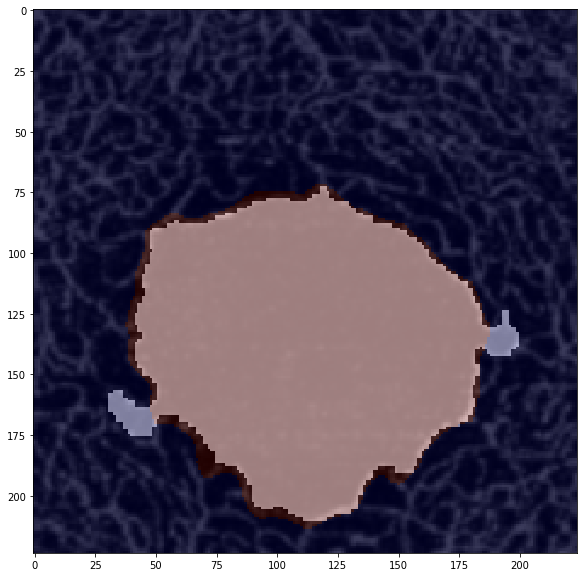

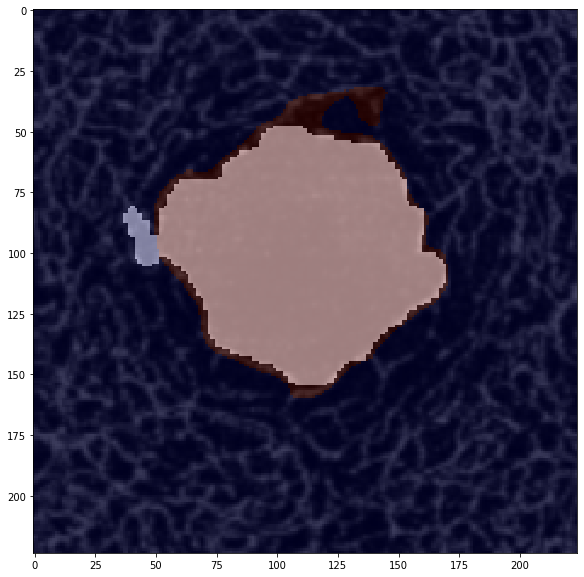

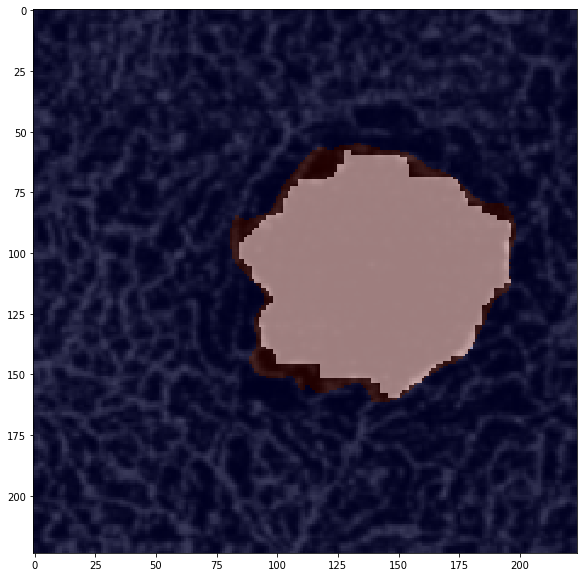

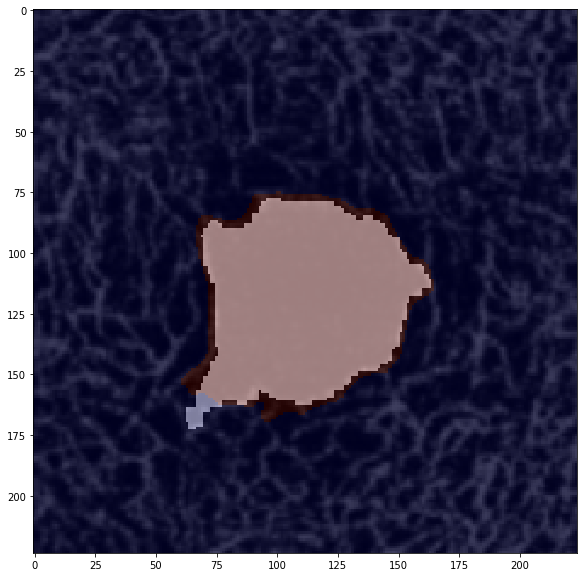

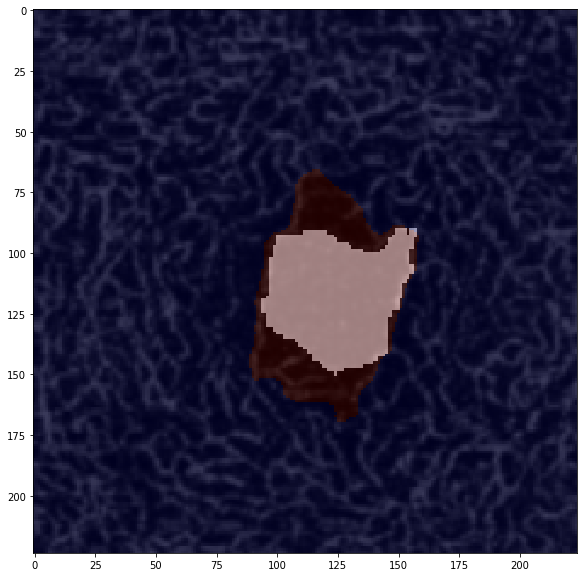

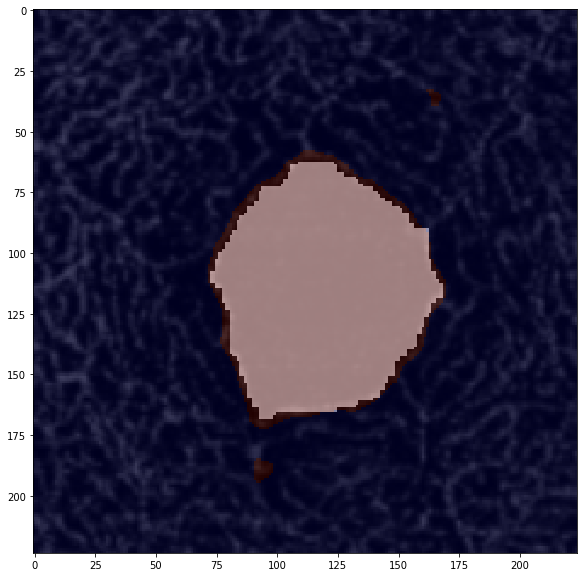

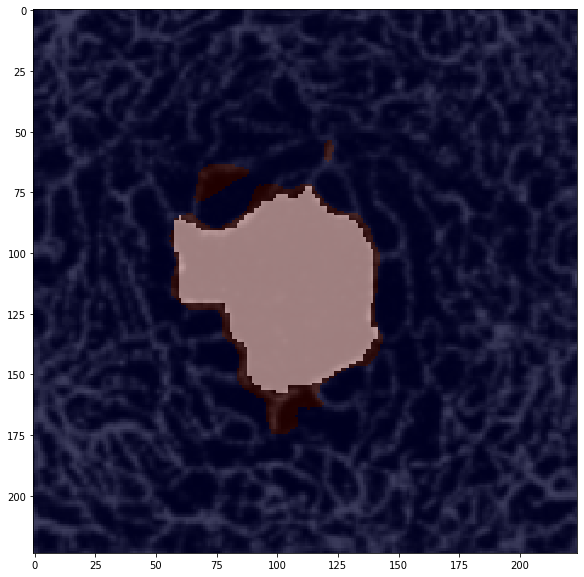

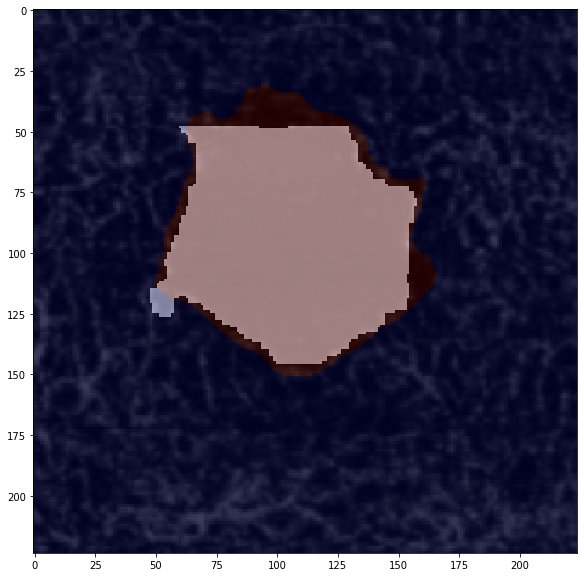

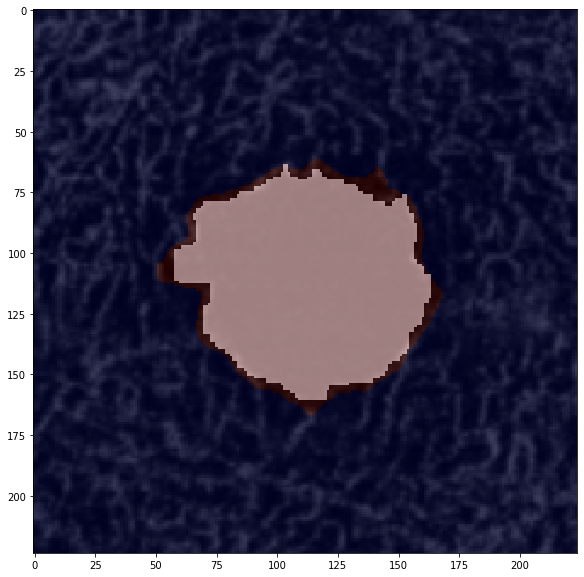

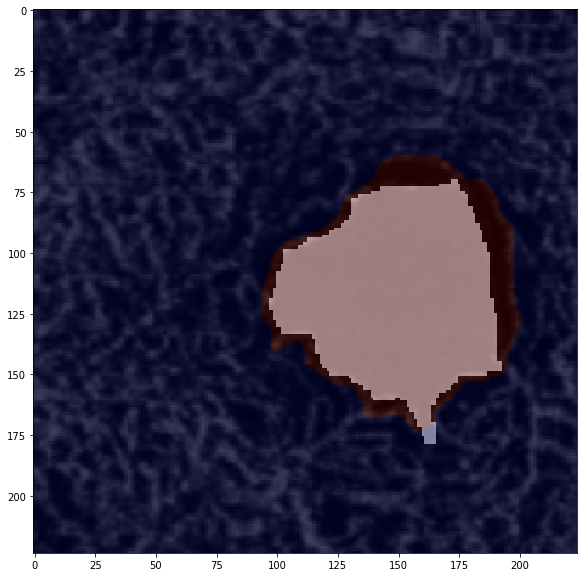

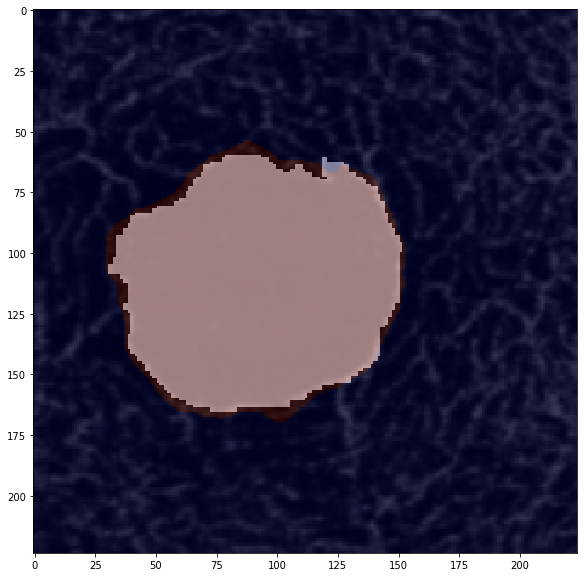

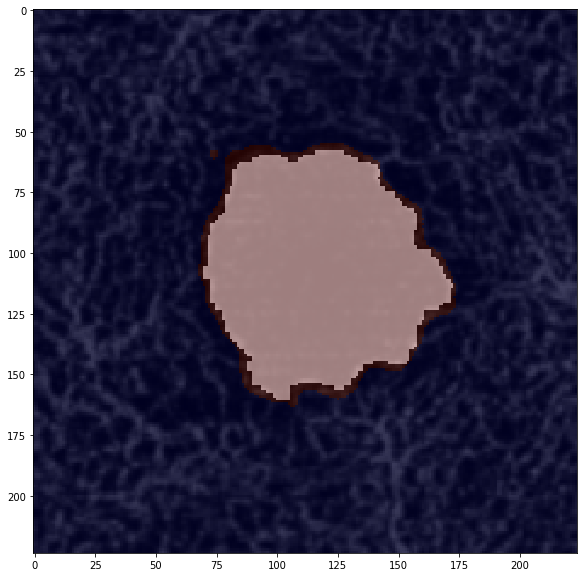

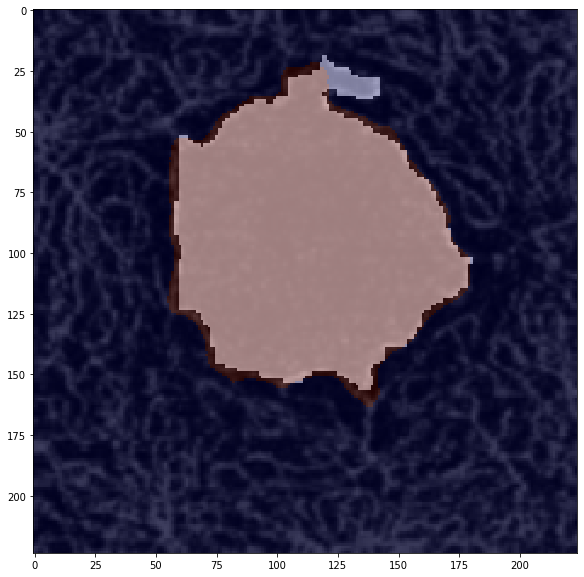

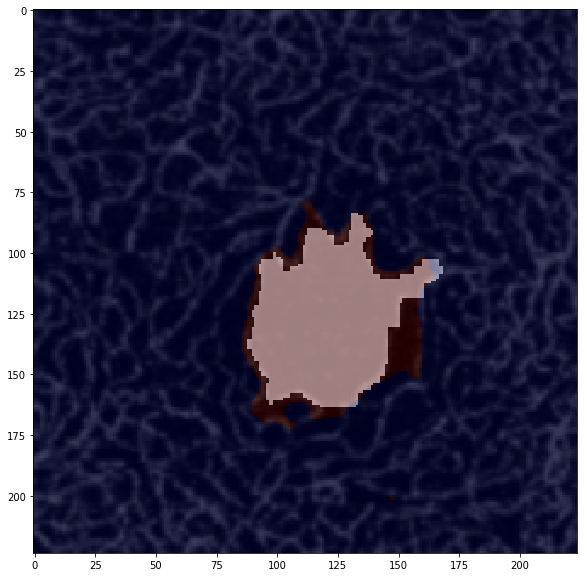

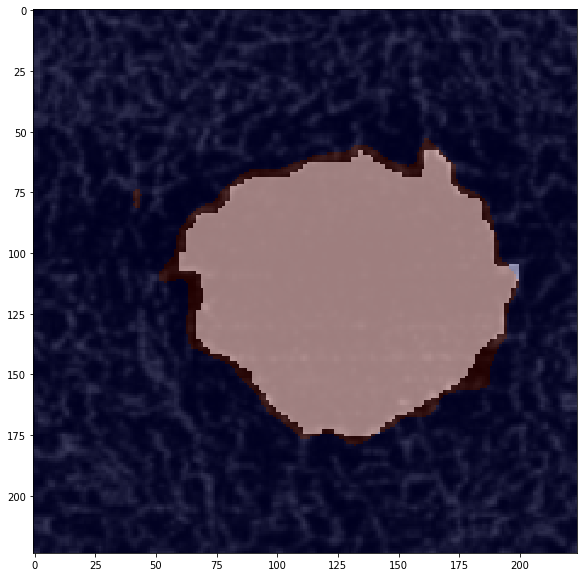

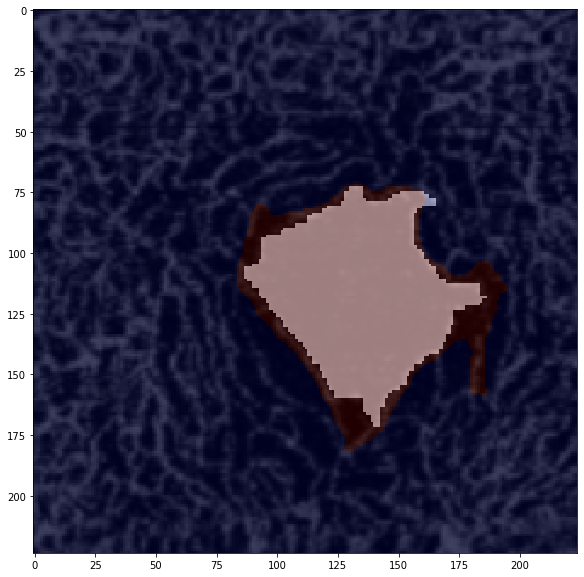

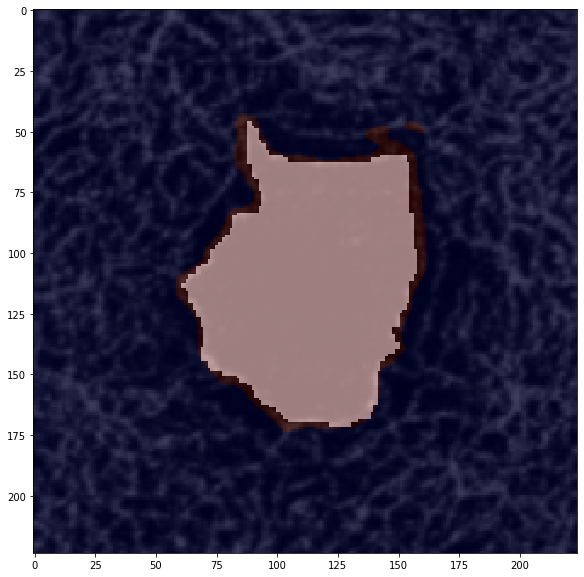

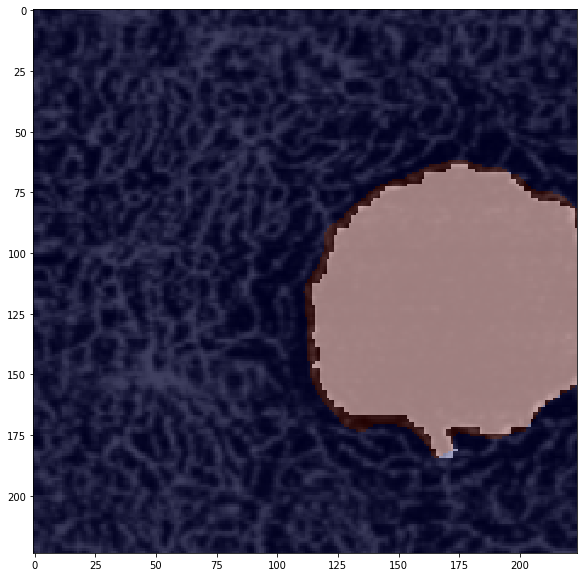

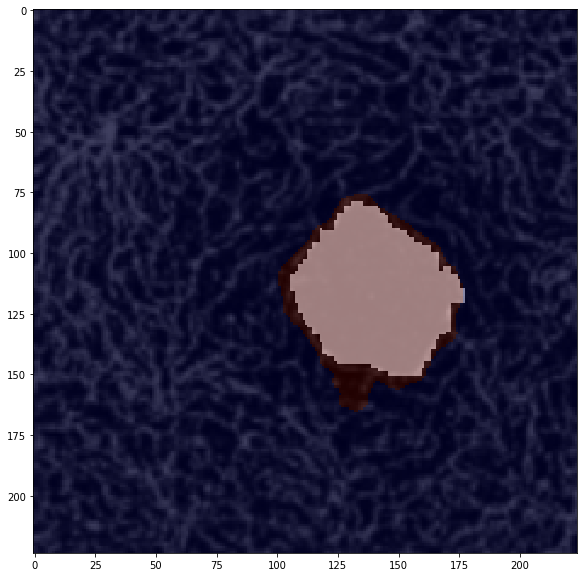

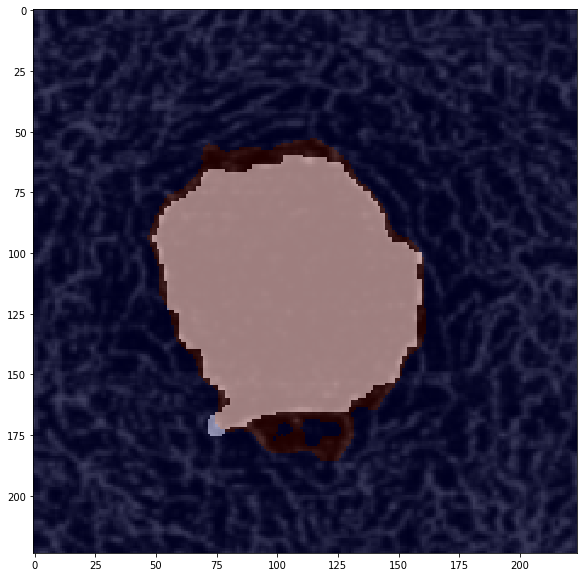

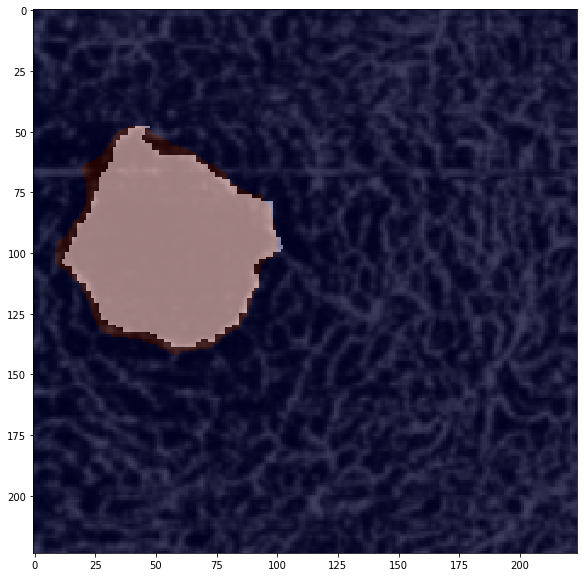

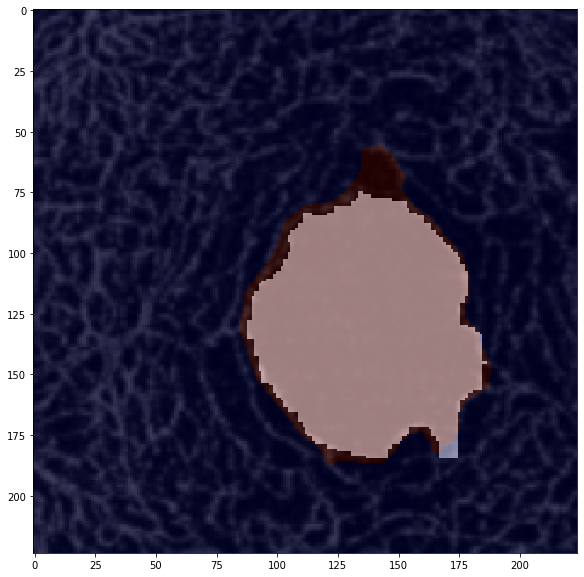

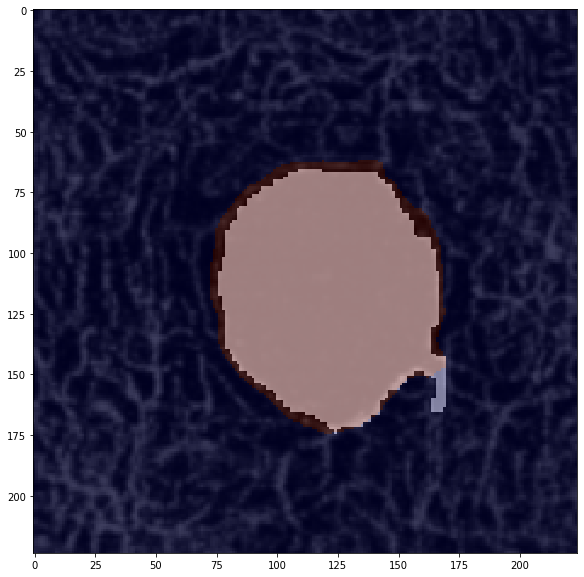

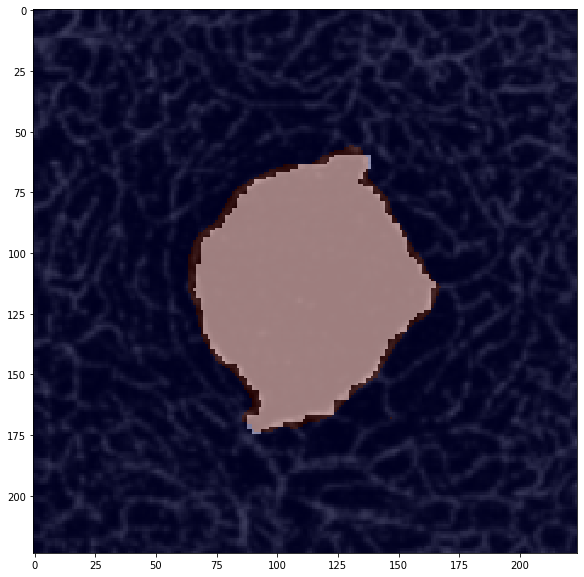

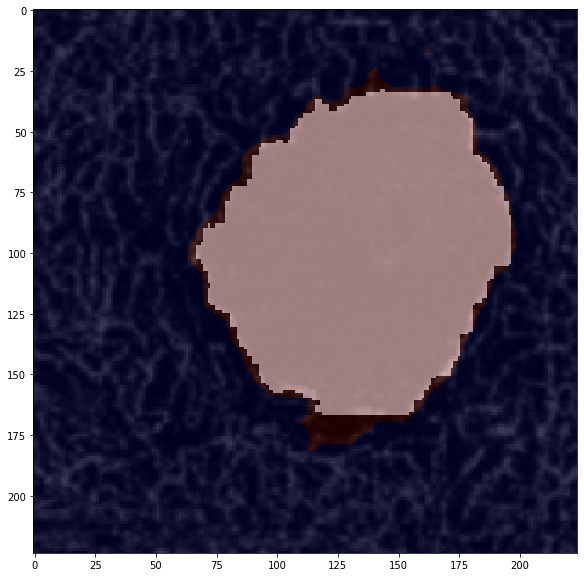

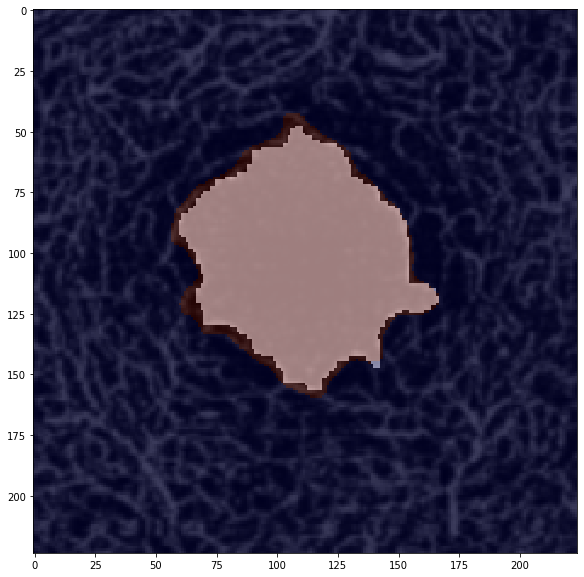

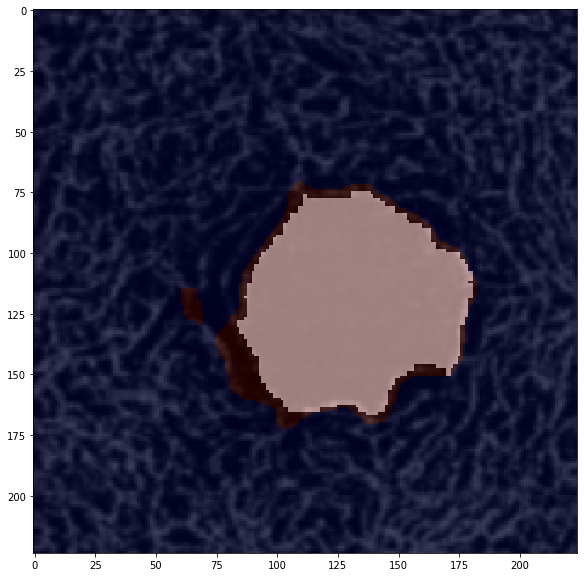

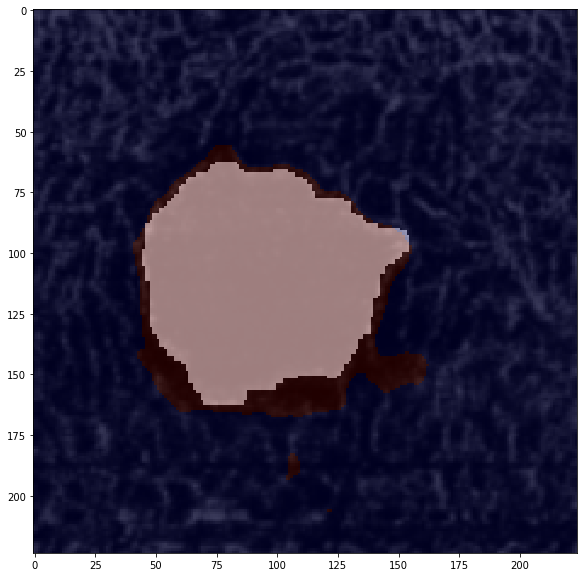

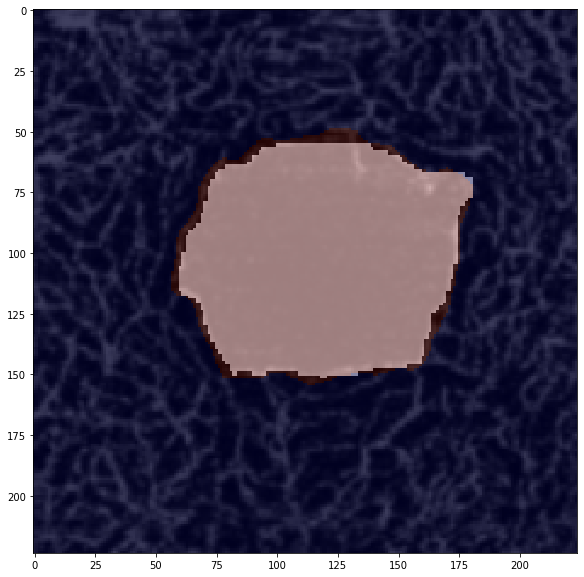

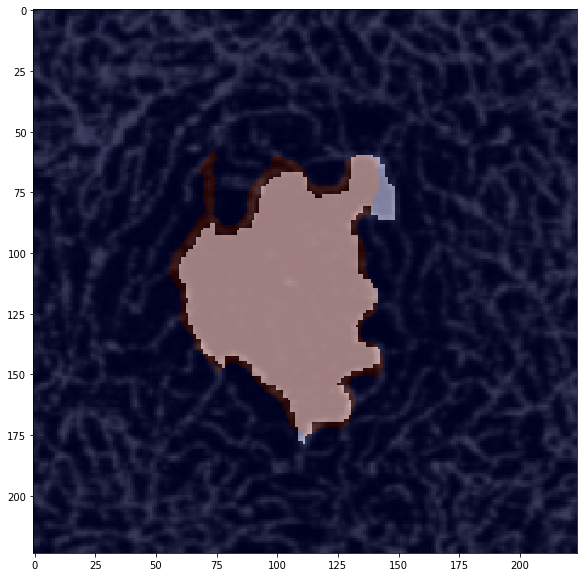

In [63]:
for image_name in test_image:
#     image_name = random.choice(test_image)
#     print(image_name)
    mask=visualizing(model,image_name,source_dir)

# Testing centercrop image

In [2]:
def train_transformation(image, mask, size, sub_size):
    tensor_transform = transforms.Compose([
        transforms.Resize((size, size)),
#         transforms.CenterCrop(sub_size),
        transforms.RandomApply([
#             transforms.RandomAffine(degrees=[-45, 45], translate=[0.15, 0.15], scale=[1.0, 1.2]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5)], p=0.85),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.CenterCrop(sub_size),
        transforms.RandomApply([
#             transforms.RandomAffine(degrees=[-45, 45], translate=[0.15, 0.15], scale=[1.0, 1.2]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5)], p=0.85),
        transforms.ToTensor()
    ])
    
    #apply transform to image and grouth truth:
    seed = np.random.randint(2147483647) # make a seed with numpy generator 
    random.seed(seed)
    image = tensor_transform(image)
    random.seed(seed) # apply this seed to target tranfsorms
    mask = mask_transform(mask)
#     mask = torch.ByteTensor(np.array(mask))

    return image, mask
def inference_transformation(image, mask, size):
    """ Transform image for validation

    Parameters
    ----------
    image: PIL.Image
        image to transform
    size: int
        size to scale

    Returns
    -------

    """
    tensor_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.CenterCrop(150),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.CenterCrop(150),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    #apply transform to image and grouth truth:
    image = tensor_transform(image)
    mask = mask_transform(mask)
#     mask = torch.ByteTensor(np.array(mask))

    return image, mask

In [13]:
im = Image.open("/home/vinhng/OCTA/dataset/valid/raw/HP-005 OD 2017-11-06T100316 OCTA  07_DVC PARon v6.9.5.100.png_cropped.png").convert("RGB")
gt = Image.open("/home/vinhng/OCTA/dataset/valid/mask/HP-005 OD 2017-11-06T100316 OCTA  07_DVC PARon v6.9.5.100.png_cropped.png")

In [14]:
image, mask =inference_transformation(im, gt, 300)

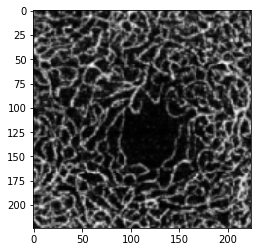

In [15]:
plt.imshow(image.permute(1,2,0))

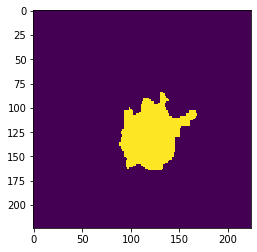

In [16]:
plt.imshow(mask.squeeze(0))

In [217]:
# def visualize(image_name,source_dir):
#     mask_name  = image_name.replace("tif","png")
#     image = Image.open(os.path.join(source_dir,image_name)).convert("RGB")
#     mask = Image.open(os.path.join(source_dir.replace("raw","mask"), mask_name))
#     image, truth_mask =  train_transformation(image, mask, 300,150)
#     plt.imshow(image.permute(1,2,0))
#     plt.show()
#     return image
# source_dir = "/home/vinhng/OCTA/dataset/test/raw"
# test_image = os.listdir(source_dir)
# for image_name in test_image:
#     image = visualize(image_name,source_dir)

In [231]:
model = get_torchvision_model("b4", True, 1)

In [233]:
trans_resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()])
image.size()

torch.Size([3, 150, 150])

In [235]:
test = trans_resize(image)
test.size()

torch.Size([3, 224, 224])

In [236]:
test = test.unsqueeze(0)
result = model(test)

# Testing other models

In [2]:
import segmentation_models_pytorch as smp

In [11]:
a = smp.Unet("se_resnext50_32x4d", encoder_weights='imagenet', classes = 1)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /home/vinhng/.cache/torch/checkpoints/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 105M/105M [05:11<00:00, 355kB/s]  


In [16]:
img = torch.randn((1,3,224,224))

In [17]:
result = a(img)